# Subdivide Cube into Tets #

We use a few simple examples to demonstrate some main concepts in mesh generation.

We will use FEniCS to plot meshes by importing a mesh into FEniCS from a list of coordinates and a connectivity table.

In [1]:
from fenics import *

%matplotlib inline

In [2]:
def import_mesh(coors, conn):
    '''Construct a mesh from list of nodal coordinates and connectivity table.'''

    dim = coors.shape[1]

    mesh = Mesh()
    editor = MeshEditor()
    editor.open(mesh, dim, dim)

    editor.init_vertices(coors.shape[0])  # number of vertices
    editor.init_cells(conn.shape[0])      # number of cells

    for i in range(coors.shape[0]):
        editor.add_vertex(i, coors[i, :])

    for i in range(conn.shape[0]):
        editor.add_cell(i, conn[i, :], )

    editor.close()
    
    return mesh

## How to subdivide a cube into tets ##

There are two major approaches to subidivde a cube into tetrahedra.

### Approach 1: subdividing cube into six tets ###
We can subdivide a cube into six tets by first subdividing it into two prisms, and then subdivide each prism into three tets.

#### Approach 1a: congruent tets ####
We may subdivide a prism into six congruent tets.

<a href='https://www.youtube.com/watch?v=ffnVCEAcOns'>
<img src='https://www.ics.uci.edu/~eppstein/projects/tetra/sixcube.gif'></a>

In [3]:
import numpy as np

# construct a list of nodes of a cube
coors = np.array([[0., 0., 0.],
                  [1., 0., 0.],
                  [1., 1., 0.],
                  [0., 1., 0.],
                  [0., 0., 1.],
                  [1., 0., 1.],
                  [1., 1., 1.],
                  [0., 1., 1.]])

In [4]:
# We define a connectivity table of six tets
tets6a = np.array([[0, 1, 2, 6],
                   [0, 5, 1, 6],
                   [0, 4, 5, 6],
                   [0, 2, 3, 6],
                   [0, 7, 4, 6],
                   [0, 3, 7, 6]], dtype=np.uintp)

We use the following code to import the tets into a mesh in FEniCS.

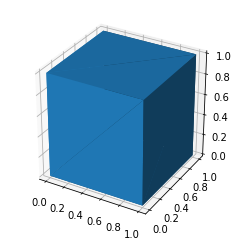

In [5]:
mesh = import_mesh(coors, tets6a)

plot(mesh)

**Important**: In general, all the tets should have the same orientation, so that the Jacobian determinant is positive everywhere, and outward face normals can be calculated correctly.

In [6]:
import sys

def check_orientation(coords, elems):
    dets = np.zeros(elems.shape[0])

    for i in range(elems.shape[0]):
        nodes = coords[elems[i,:], :]

        dets[i] = np.linalg.det(nodes[[1, 2, 3],:]-nodes[[0, 0, 0],:])

    if min(dets) <= 0.:
        print('Warning: Mimumum volume is not positive.', file=sys.stderr)
        
    return dets

In [7]:
dets = check_orientation(coors, tets6a)
dets

array([ 1.,  1.,  1.,  1.,  1.,  1.])

**Warning**:  FEniCS reorders connectivity table in ascending order. This destroys the orientation of the elements. This can be a big headache for mesh manipulation using FEniCS's `Mesh` objects. In addition, this is a reason why FEniCS can only support simplicial elements.

In [8]:
print(mesh.cells())
check_orientation(mesh.coordinates(), mesh.cells())

[[0 1 2 6]
 [0 1 5 6]
 [0 4 5 6]
 [0 2 3 6]
 [0 4 6 7]
 [0 3 6 7]]


array([ 1., -1.,  1.,  1.,  1., -1.])

If you export a mesh from FEniCS, make sure you check the volumes, and flip two nodes if the volume of an element is negative.

### Approach 1b: non-congruent tets ###

The tets may be non-congruent. We define a connectivity table of six tetrahedra. 

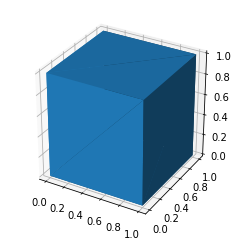

In [9]:
tets6b = np.array([[0, 1, 3, 4], 
                   [1, 3, 4, 5], 
                   [4, 7, 5, 3],
                   [1, 2, 3, 5], 
                   [2, 3, 5, 7], 
                   [2, 5, 6, 7]], dtype=np.uintp)

mesh = import_mesh(coors, tets6a)
plot(mesh)

In [10]:
dets = check_orientation(coors, tets6b)
dets

array([ 1.,  1.,  1.,  1.,  1.,  1.])

### Approach 2: subdividing cube into five tets ###

Another approach is to subdivide the cube into five tets, with a regular tetrahedron in the middle.

<a href='https://www.youtube.com/watch?v=XAhgw2Z4T2M'>
<img src='https://www.ics.uci.edu/~eppstein/projects/tetra/fivecube.gif'></a>

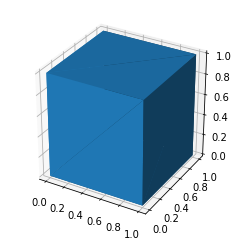

In [11]:
tets5 = np.array([[0, 1, 3, 4],
                  [1, 2, 3, 6],
                  [3, 4, 6, 7],
                  [1, 3, 4, 6],
                  [1, 4, 5, 6]], dtype=np.uintp)

mesh = import_mesh(coors, tets6a)
plot(mesh)

In [12]:
dets = check_orientation(coors, tets5)
dets

array([ 1.,  1.,  1.,  2.,  1.])

## Comparisons ##

Apprach 1a is commonly used because of its simplicity. It is how FEniCS's function `UnitCubeMesh` generates tetrahedral mesh for unit cube.

(6000, 4)

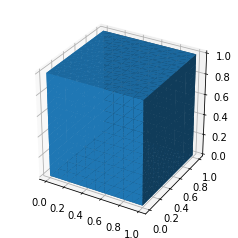

In [13]:
mesh = UnitCubeMesh(10, 10, 10)
plot(mesh)
mesh.cells().shape

However, is it the best approach?

### Dihedral angles ###
Compute dihedral angles of tets. 

In [14]:
import math
import itertools

def compute_dihedral_angles_tet(nodes):
    '''Compute dihedral angles of a tetrahedron '''
    
    faces = np.array([[0, 1, 2], [1, 0, 3], [0, 2, 3], [2, 1, 3]])

    normals = np.zeros([4, 3], dtype=float)
    
    for i in range(4):
        v1 = nodes[faces[i, 1], :] - nodes[faces[i, 0], :]
        v2 = nodes[faces[i, 2], :] - nodes[faces[i, 0], :]
        normals[i, :] = np.cross(v1, v2)
        normals[i, :] /= np.linalg.norm(normals[i, :])

    dihedral_angles = np.zeros(6)
    pairs = np.array(list(itertools.permutations([0, 1, 2, 3], 2)))

    for i in range(6):
        dihedral_angles[i] = math.acos(-np.dot(normals[pairs[i, 0], :],
                             normals[pairs[i, 1], :])) / math.pi * 180.
        
    return dihedral_angles

def compute_dihedral_angles(coors, tets):
    angles = np.zeros([tets.shape[0], 6])

    for i in range(tets.shape[0]):
        angles[i, :] = compute_dihedral_angles_tet(coors[tets[i, :], :])
        
    angles = np.sort(angles)       
    return angles

In [15]:
angles = compute_dihedral_angles(coors, tets6a)

np.set_printoptions(precision=2)
print(angles)

[[ 45.  45.  60.  90.  90.  90.]
 [ 45.  45.  60.  90.  90.  90.]
 [ 45.  45.  60.  90.  90.  90.]
 [ 45.  45.  60.  90.  90.  90.]
 [ 45.  45.  60.  90.  90.  90.]
 [ 45.  45.  60.  90.  90.  90.]]


In [16]:
angles = compute_dihedral_angles(coors, tets6b)
print(angles)

[[  54.74   54.74   90.     90.     90.     90.  ]
 [  35.26   35.26   35.26   45.    120.    125.26]
 [  45.     45.     90.     90.     90.     90.  ]
 [  45.     45.     90.     90.     90.     90.  ]
 [  35.26   45.     45.     45.    120.    125.26]
 [  54.74   54.74   54.74   54.74   90.     90.  ]]


In [17]:
angles = compute_dihedral_angles(coors, tets5)
print(angles)

[[ 54.74  54.74  90.    90.    90.    90.  ]
 [ 54.74  54.74  90.    90.    90.    90.  ]
 [ 54.74  54.74  54.74  54.74  90.    90.  ]
 [ 70.53  70.53  70.53  70.53  70.53  70.53]
 [ 54.74  54.74  54.74  54.74  90.    90.  ]]


### Angles within faces ###
For completeness, we should also compare angles within faces. There are many of them, so we only print out the unique angles.

In [18]:
def compute_edge_angles_tet(nodes, edge_angles):
    '''Compute edge angles within a tetrahedron '''
    
    faces = np.array([[0, 1, 2], [1, 0, 3], [0, 2, 3], [2, 1, 3]])
    edges = np.array([[0, 1], [1, 2], [2, 0], [0, 1]])

    normals = np.zeros([4, 3], dtype=float)
    
    for i in range(4):
        face = faces[i, :]

        a = [0, 0, 0]

        for j in range(3):
            v1 = nodes[face[edges[j, 1]], :] - nodes[face[edges[j, 0]], :]
            v2 = nodes[face[edges[j+1, 1]], :] - nodes[face[edges[j+1, 0]], :]

            a[j] = (math.acos(-np.dot(v1, v2) / 
                                            np.linalg.norm(v1) / np.linalg.norm(v2)) / 
                                  math.pi * 180.)
            a[j] = round(a[j], 2)
        a.sort()
        
        if a not in edge_angles:
            edge_angles.append(a)

def compute_edge_angles(coors, tets):
    angles = []

    for i in range(tets.shape[0]):
        compute_edge_angles_tet(coors[tets[i, :], :], angles)

    return np.array(angles)

In [19]:
angles = compute_edge_angles(coors, tets6a)
print(angles)

[[ 45.    45.    90.  ]
 [ 35.26  54.74  90.  ]]


In [20]:
angles = compute_edge_angles(coors, tets6b)
print(angles)

[[ 45.    45.    90.  ]
 [ 60.    60.    60.  ]
 [ 35.26  54.74  90.  ]]


In [21]:
print(compute_edge_angles(coors, tets5))

[[ 45.  45.  90.]
 [ 60.  60.  60.]]


### Longest edge length ###

In [22]:
def compute_longest_edge_tet(nodes):
    '''Compute dihedral angles of a tetrahedron '''

    edges = np.array((list(itertools.combinations([0, 1, 2, 3], 2))))
    lens = np.zeros(6)
    
    for i in range(6):
        v = nodes[edges[i, 1], :] - nodes[edges[i, 0], :]
        lens[i] = np.linalg.norm(v)

    return max(lens)

def compute_longest_edge(coors, tets):
    lens = np.zeros(tets.shape[0])

    for i in range(tets.shape[0]):
        lens[i] = compute_longest_edge_tet(coors[tets[i, :], :])
        
    return max(lens)

In [23]:
print(compute_longest_edge(coors, tets6a))

1.73205080757


In [24]:
print(compute_longest_edge(coors, tets6b))

1.73205080757


In [25]:
print(compute_longest_edge(coors, tets5))

1.41421356237
